In [18]:
%reload_ext autoreload
%autoreload 2

from NSGPy.torch.model import NSGPRegression
import torch
import numpy as np
from pyDOE2.doe_lhs import lhs
import matplotlib.pyplot as plt
from NSGPy.utils.inducing_functions import f_kmeans, f_random

### Generate train data

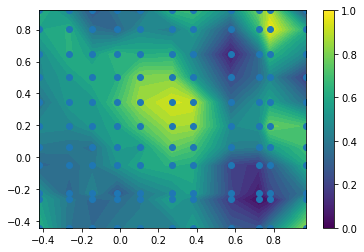

In [114]:
n = 11
np.random.seed(0)

def simulate(a, b):
    bi = np.pi * (2*a + 0.5*b + 1)
    return 0.1 * (np.sin(a*bi) + np.sin(b.T*bi))

x1 = np.sort(lhs(1, 11, random_state=0)*1.5 - 0.5, axis=0)
x2 = np.sort(lhs(1, 11, random_state=1)*1.5 - 0.5, axis=0)
X1, X2 = np.meshgrid(x1, x2)
X = np.array([(a,b) for a,b in zip(X1.ravel(), X2.ravel())])
y = simulate(X[:,0], X[:,1]).reshape(-1,1) + np.random.normal(0, 0.025, (121,1))

plt.contourf(X1, X2, y.reshape(n,n), levels=30);
plt.scatter(X[:,0], X[:,1]);
plt.colorbar();

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

### Scaling

In [115]:
X = (X - X.mean(dim=0))/X.std(dim=0)
y = (y - y.mean())/y.std()

### Training

In [119]:
seed = 0
model = NSGPRegression(X, y, 8, f_inducing=f_kmeans, jitter=10**-8, 
                       random_state=seed, local_noise=True, local_std=True, device='cpu')
print(model.params)
# %debug
model.optimize_restarts(n_restarts=5, epochs=500, lr=0.1, gran=10000, m=0, optim='lbfgs', verbose=True)
with torch.no_grad():
    mean, var = model.predict(X)
    mean = mean.view(-1)
    std2 = torch.sqrt(var.diag())*2
    ls = model.get_LS(X)
print(model.params)

{'local_gp_ls': tensor([0.1610, 1.1758], dtype=torch.float64, requires_grad=True), 'local_gp_std': tensor([0.3615, 0.4681], dtype=torch.float64, requires_grad=True), 'local_gp_noise_std': tensor([0.7289, 0.9132], dtype=torch.float64, requires_grad=True), 'local_ls': tensor([[0.8503, 0.1058],
        [2.5423, 0.5343],
        [0.0465, 0.1769],
        [0.6333, 0.2485],
        [0.2271, 0.0540],
        [0.3282, 1.0359],
        [0.5831, 0.5346],
        [0.8579, 1.2936]], dtype=torch.float64, requires_grad=True), 'global_gp_std': tensor([0.7600], dtype=torch.float64, requires_grad=True), 'global_gp_noise_std': tensor([0.9845], dtype=torch.float64, requires_grad=True)}
restart: 0 cholesky failure
restart: 1 cholesky failure
restart: 2 cholesky failure
restart: 3 loss: -1986.963787574968
restart: 4 loss: -2060.2707319772403
{'local_gp_ls': tensor([7.3847, 7.7413], dtype=torch.float64, requires_grad=True), 'local_gp_std': tensor([1.0001e+00, 1.0679e-05], dtype=torch.float64, requires_grad=

### Testing

In [120]:
np.random.seed(0)
n = 31
x1_test = np.sort(lhs(1, n, random_state=3)*1.5 - 0.5, axis=0)
x2_test = np.sort(lhs(1, n, random_state=4)*1.5 - 0.5, axis=0)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)

X_test = torch.tensor(np.array([(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]))
y_test = torch.tensor(np.array([simulate(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]).reshape(-1,1))
# print(X_test.shape, y_test.shape)

X_test = (X_test - X_test.mean(dim=0))/X_test.std(dim=0)
y_test = (y_test - y_test.mean())/y_test.std()

with torch.no_grad():
    mean, var = model.predict(X_test)
    ls = model.get_LS(X_test)
    print(torch.mean(torch.square(y_test-mean))/torch.var(y_test))

tensor(0.0824, dtype=torch.float64)


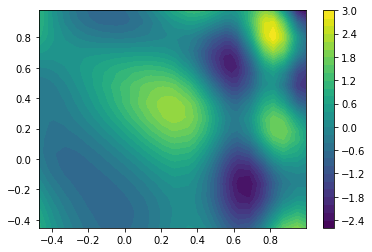

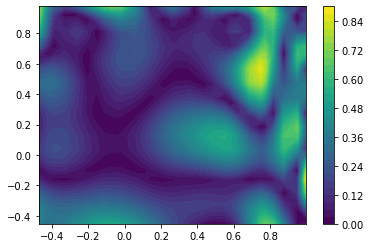

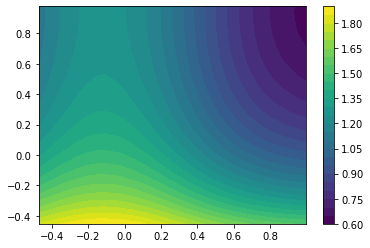

In [121]:
plt.contourf(X1_test, X2_test, mean.reshape(n,n), levels=30);
plt.colorbar();

plt.figure()
# plt.scatter(model.X_bar[:,0], model.X_bar[:,1], c='r',zorder=10)
plt.contourf(X1_test, X2_test, torch.abs(mean.reshape(n,n)-y_test.reshape(n,n)), levels=30);
plt.colorbar();

plt.figure()
plt.contourf(X1_test, X2_test, torch.norm(torch.cat(ls, dim=1), dim=1).reshape(n,n), levels=30);
plt.colorbar();

### Comparing with Stationary GP


Name : GP regression
Objective : 109.0501340035425
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   1.2749922807611578  |      +ve      |        
  rbf.lengthscale          |                 (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.08002359928891749  |      +ve      |        


 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/likelihoods/gaussian.py:119: RuntimeWarning:invalid value encountered in sqrt
 /home/patel_zeel/anaconda3/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


(GP_regression.rbf.lengthscale:
 Param([0.37458791, 0.54053844]),
 array([0.28288443]))

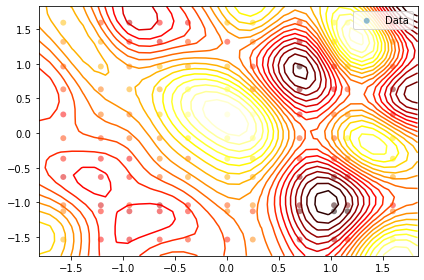

In [122]:
np.random.seed(0)
# !pip install GPy
import GPy
m = GPy.models.GPRegression(X.numpy(), y.numpy(), GPy.kern.RBF(2, ARD=True))
m.optimize_restarts(20, verbose=False);
m.plot()
print(m)
m.kern.lengthscale, m['Gaussian_noise.variance']**.5

0.09540679831782116

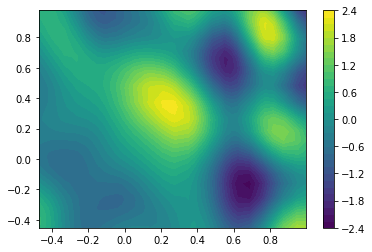

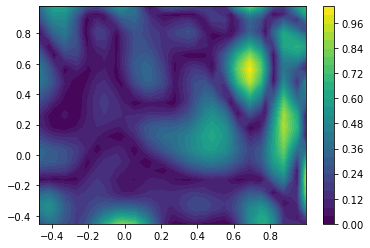

In [39]:
pred_y = m.predict(X_test.numpy())[0]

plt.contourf(X1_test, X2_test, pred_y.reshape(n,n), levels=30)
plt.colorbar()

plt.figure()
plt.contourf(X1_test, X2_test, np.abs(pred_y.reshape(n,n)-y_test.numpy().reshape(n,n)), levels=30)
plt.colorbar();
np.mean(np.square(y_test.numpy().ravel()-pred_y.ravel()))/np.var(y_test.numpy())